# Data Science Case Study

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from shapely.geometry import Point
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely import wkt
from shapely.validation import make_valid

import holidays
import time

from rapidfuzz import process, fuzz
from typing import Optional
import pandas as pd
from tqdm import tqdm

plt.style.use('ggplot')
pd.options.display.max_columns = 500
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

## Read Data

In [289]:
data_path = Path.cwd().resolve().parents[1] / "data"
sales = pd.read_csv(data_path / "sales.csv", index_col=0)
stations = pd.read_csv(data_path / "stations.csv", index_col=0)

___Sales Data Dictionary___

    - date: yyyy-mm-dd format. increments of one day. not unique.
    - sales: number of sales on that given day, relative to the station
    - station: name of a station in the UK

___Stations Data Dictionary___

    - station: name of the station in the UK
    - lat: latitude coordinate
    - lon: longitude coordinate
    - operator: responible entity for the ticket / journey

## Operator Observation

    Trainline is a different kind of entity to English / Welsh / Scottish Rail. 
    The latter is a private or public body that own the trains and journeys
    the other is a vendor which sells tickets on behalf of these bodies.

***Why this matters***

    Railways may sell tickets through many channels and Trainline is simply just one of them (i.e. tickets at station, their own website etc). A sale to trainline is also a sale to whichever railway operates at the station.

    We will need to map stations to the correct body based on the lat/lon data so that sales totals for each railway is fully represenative. 
    (e.g. when lat/lon falls inside the Wales then attribute sales to Welsh Railway.)

***Risks***

    Trainline take a portion of the ticket sales as revenue and the rest is passed onto the body that owns the station. Care will need to be taken to ensure reasonable estimates.


***From now on***

***Railways - refers to the english/welsh/scottish railway companies***

***Trainline - will be refered to by its namesake***


## Engineering Features & Cleaning

### Mapping stations to nations

Downloaded GeoJSON object from Gov Website for mapping
https://geoportal.statistics.gov.uk/datasets/e4cab2a2419f46d7847dafb50a159aa7_0/explore

In [290]:
# From my understanding given the resolution of the gov file, error could be up to 1000m. 
# This is forgivable given that nations are large. 
# If error is over 1000m then it is likely mapped poorly

# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations["lon"], stations["lat"]),
    crs="EPSG:4326"
)
countries = gpd.read_file(data_path / "countries.geojson").to_crs(gdf_stations.crs)

# Buffer stations by x meters then check point-in-polygon
gdf_stations_m = gdf_stations.to_crs(27700)
countries_m = countries.to_crs(27700)
x = 1000
gdf_stations_buf = gdf_stations_m.copy()
gdf_stations_buf["geometry"] = gdf_stations_buf.buffer(x)

joined = gpd.sjoin(
    gdf_stations_buf,
    countries_m[["CTRY22NM", "geometry"]],
    how="left",
    predicate="intersects"
)
gdf_stations_w_nation = (
    joined.rename(columns={"CTRY22NM": "nation"})
          .drop(columns=["geometry", "index_right"], errors="ignore")
)

# Checking errors clear
gdf_stations_w_nation.query("nation.isna()")

,station,lat,lon,operator,nation


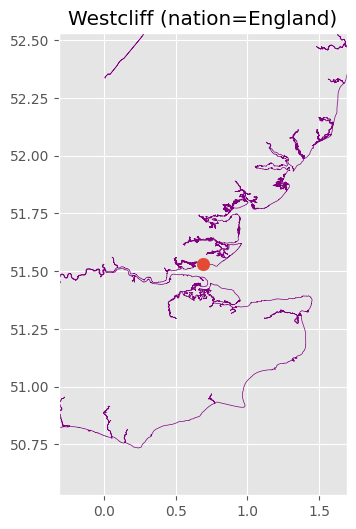

Westcliff → England: 572.7 m


572.7037673043183

In [291]:
# Sanity Check our coordinates - none should have errors above 1000m
station = "Westcliff"
nation = "England"

def _pick_station_row(df: gpd.GeoDataFrame, station: str, prefer_non_null_nation=True):
    sub = df.loc[df["station"] == station]
    if sub.empty:
        raise ValueError(f"Station '{station}' not found.")
    if prefer_non_null_nation and "nation" in sub.columns and sub["nation"].notna().any():
        sub = sub[sub["nation"].notna()]
    return sub.iloc[0]

def zoom_station(df: gpd.GeoDataFrame, station: str, pad_deg: float = 1.0):
    row = _pick_station_row(df, station)
    pt = gpd.GeoSeries([Point(row.lon, row.lat)], crs="EPSG:4326")

    ax = countries.plot(figsize=(6, 6), edgecolor="purple", facecolor="none")
    pt.plot(ax=ax, markersize=80)
    plt.xlim(row.lon - pad_deg, row.lon + pad_deg)
    plt.ylim(row.lat - pad_deg, row.lat + pad_deg)
    title_nation = row["nation"] if "nation" in row else None
    plt.title(f"{station} (nation={title_nation})")
    plt.show()

def location_offset_error(station: str, nation: str) -> float:
    row = _pick_station_row(gdf_stations, station, prefer_non_null_nation=False)
    pt = gpd.GeoSeries([Point(row.lon, row.lat)], crs="EPSG:4326").to_crs(27700).iloc[0]
    sel = countries.loc[countries["CTRY22NM"] == nation]
    if sel.empty:
        raise ValueError(f"Nation '{nation}' not found in countries['CTRY22NM'].")
    poly = sel.to_crs(27700).geometry.union_all()
    dist_m = pt.distance(poly)
    print(f"{station} → {nation}: {dist_m:.1f} m")
    return float(dist_m)

zoom_station(df=gdf_stations_w_nation,station=station)
location_offset_error(station=station, nation=nation)


In [292]:
# Now given the nation data we can map stations to railways
gdf_stations_w_nation["railway"] = gdf_stations_w_nation.apply(
    lambda row: (
        "English Rail" if row["operator"] == "Trainline" and row["nation"] == "England" else
        "Scottish Rail" if row["operator"] == "Trainline" and row["nation"] == "Scotland" else
        "Welsh Rail" if row["operator"] == "Trainline" and row["nation"] == "Wales" else
        row["operator"]
    ),
    axis=1
)
# Add a flag for trainline figures
gdf_stations_w_nation["trainline_assisted_sales"] = (gdf_stations_w_nation["operator"] == "Trainline").astype(bool)
gdf_stations_w_nation.rename(columns={"operator": "source_operator"}, inplace=True)


In [293]:
# Check one-to-one realationship between stations and operators before engineering steps
gdf_stations_w_nation.groupby('station')['source_operator'].nunique().sort_values(ascending=False)

station
Exeter Central        2
Abbey Wood            1
Oakham                1
Orpington             1
Ormskirk              1
                     ..
Forres                1
Ford Newton           1
Folkestone West       1
Folkestone Central    1
York                  1
Name: source_operator, Length: 1259, dtype: int64

In [294]:
gdf_stations_w_nation.query("station == 'Exeter Central'")

,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales
388,Exeter Central,51.46,-0.90,Trainline,England,English Rail,True
389,Exeter Central,50.72,-3.53,English Rail,England,English Rail,False


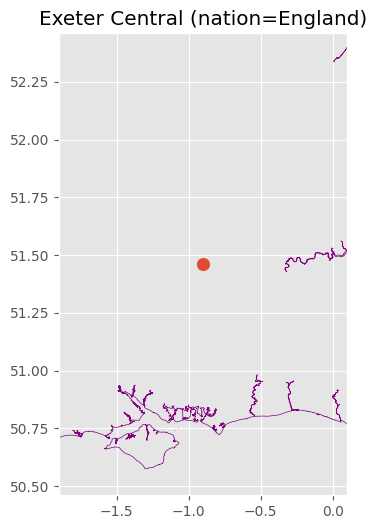

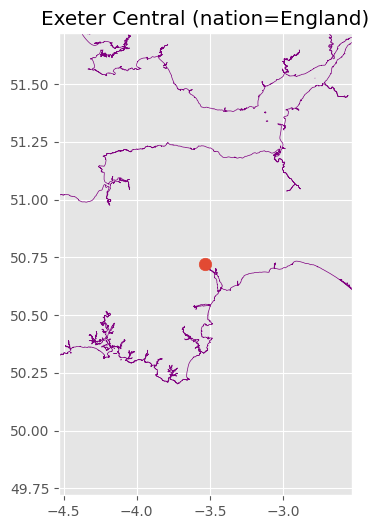

(None, None)

In [295]:
# Bottom one is correct
zoom_station(
    df=gdf_stations_w_nation.query("station == 'Exeter Central' & source_operator == 'Trainline'"),
    station='Exeter Central'
), zoom_station(
    df=gdf_stations_w_nation.query("station == 'Exeter Central' & source_operator == 'English Rail'"),
    station='Exeter Central'
)

In [296]:
# Because of the incorrect lat/lon we are dropping the row. 
# Hard to say whether Exeter Central should update to be Trainline or whether the Trainline entry is wrong
# As the row was wrong we shall leave Exeter as False for Trainline Assisted Sales for now
gdf_stations_w_nation = gdf_stations_w_nation[~((gdf_stations_w_nation.station == "Exeter Central") & (gdf_stations_w_nation.source_operator == "Trainline"))]

### Join datasets

***State***

    It looks like the stations don't match 1-1 between the datasets.
    Stations listed in the stations dataset can either match with the stations in sales or not at all.
    For example '%manchester%' has 3 entries in Sales but in Stations it has 8 entries.

***Evaluation***

    Some match 1-1 and some will likely match once processed and fuzzy matched with high confidence.
    We can then match by distance being close (i.e. within somesort of range).
    Doing this where we can can allow us to match trainline_assisted_sales.

    However, if for some examples this doesn't work thats okay.
    Due to the logic with operator = 'trainline' which we did above we can infer the acutal railway by region location, station dataset doesn't have sales data, coords can be retrieved reliably from online sources/libraries there isn't much value from trying to match data further or whitespacing by populating train stations which have no sales data.

***Actions***

    - Normanlise names
    - Match using high confidence fuzzy
    - Match using neaby distance.

In [297]:
def nearest_in_sales(lat, lon):
    R = 6371000.0  # Earth radius in meters
    
    qlat = np.radians(lat)
    qlon = np.radians(lon)

    dlat = sales_lat_rad - qlat
    dlon = sales_lon_rad - qlon
    a = np.sin(dlat/2.0)**2 + np.cos(qlat) * np.cos(sales_lat_rad) * np.sin(dlon/2.0)**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    d = R * c

    idx = int(np.argmin(d))
    return (sales_stn.loc[idx, 'station'],
            float(d[idx]),
            float(sales_stn.loc[idx, 'lat']),
            float(sales_stn.loc[idx, 'lon']))

In [298]:
geolocator = Nominatim(user_agent="station_locator")

def get_coords(name):
    try:
        loc = geolocator.geocode(f"{name} railway station, UK")
        if loc:
            return loc.latitude, loc.longitude
    except Exception:
        pass
    return None, None

unique_stations = sales['station'].drop_duplicates().to_list()

coords = {}
for name in unique_stations:
    lat, lon = get_coords(name)
    coords[name] = (lat, lon)
    time.sleep(1)

# Assign values back to sales dataset
sales['lat'] = sales['station'].map(lambda s: coords.get(s, (None, None))[0])
sales['lon'] = sales['station'].map(lambda s: coords.get(s, (None, None))[1])

sales.to_csv(data_path / "sales_with_coords.csv")
# sales = pd.read_csv(data_path / "sales_with_coords.csv", index_col=0)

In [299]:
def match_names(original_df: pd.DataFrame,
                name_column: str,
                matching_df: pd.DataFrame,
                matching_names: str,
                alt_names: Optional[str] = None,
                min_match_score: int = 90):
    matches = []
    output_df = original_df

    fuzzy_names_to_match = original_df[name_column].tolist()
    svc_names_list = matching_df[matching_names].tolist()

    # Default to empty dict if no alternate names provided
    if alt_names is None:
        alternate_name_dict = {}
    else:
        alternate_name_dict = dict(zip(original_df[name_column], original_df[alt_names]))

    for name in tqdm(fuzzy_names_to_match, desc="Matching Names", unit="name"):
        best_matches = process.extract(name, svc_names_list, scorer=fuzz.ratio)

        # If a match is found for the first name, add it to the matches list
        if any(match[1] >= min_match_score for match in best_matches):
            for match in best_matches:
                if match[1] >= min_match_score:
                    matches.append((match[0], name, match[1]))
        else:
            # Try matching with the alternate name if no match is found
            alternate_name = alternate_name_dict.get(name, None)
            if alternate_name:
                alternate_matches = process.extract(alternate_name, svc_names_list, scorer=fuzz.ratio)
                # If a match is found with the alternate name, add it to the matches list
                if any(match[1] >= min_match_score for match in alternate_matches):
                    for match in alternate_matches:
                        if match[1] >= min_match_score:
                            matches.append((match[0], name, match[1]))

    # Create DataFrame of matched results
    matched_df = output_df[output_df[name_column].isin([m[1] for m in matches])].copy()

    matched_by_dict = {m[1]: m[0] for m in matches}
    match_score_dict = {m[1]: m[2] for m in matches}

    matched_df['matched_by'] = matched_df[name_column].map(matched_by_dict)
    matched_df['match_score'] = matched_df[name_column].map(match_score_dict)

    return matched_df

_station_sales = match_names(sales, 'station', gdf_stations_w_nation, 'station', min_match_score=95)

Matching Names: 100%|██████████| 70100/70100 [00:02<00:00, 26920.06name/s]


In [300]:
# All matching was 100% scores, hence we can just do a left join now
_station_sales.describe()

,sales,lat,lon,match_score
count,70100.000000,56080.000000,56080.000000,70100.0
mean,337.535624,52.400404,-1.375909,100.0
std,390.673461,1.278432,1.282918,0.0
min,92.314156,50.377642,-4.258436,100.0
25%,135.779942,51.490354,-2.232282,100.0
50%,200.444485,52.042377,-1.345491,100.0
75%,371.568482,53.243475,-0.296837,100.0
max,2754.247272,55.951902,1.306417,100.0


In [301]:
# As all were matches with this step the matching by distance is no longer needed
station_sales = pd.merge(
    sales,
    gdf_stations_w_nation[[
        "station", "source_operator", "nation", "railway",
        "trainline_assisted_sales", "lat", "lon"
    ]],
    on="station",
    how="left",
    suffixes=("", "_right")
)

# Fill missing lat/lon in the left df with right-side values
for col in ["lat", "lon"]:
    station_sales[col] = station_sales[col].fillna(station_sales[f"{col}_right"])

# Drop temporary columns
station_sales = station_sales.drop(columns=["lat_right", "lon_right"])


In [302]:
station_sales[station_sales['station'].str.contains('manchester', case=False, na=False)].head()

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales
0,2023-01-01,1346.840438,Manchester Piccadilly,53.47722,-2.23014,English Rail,England,English Rail,False
1,2023-01-02,1347.696314,Manchester Piccadilly,53.47722,-2.23014,English Rail,England,English Rail,False
2,2023-01-03,1349.757360,Manchester Piccadilly,53.47722,-2.23014,English Rail,England,English Rail,False
3,2023-01-04,1354.646786,Manchester Piccadilly,53.47722,-2.23014,English Rail,England,English Rail,False
4,2023-01-05,1348.356770,Manchester Piccadilly,53.47722,-2.23014,English Rail,England,English Rail,False


### Adding Date time Features

In [303]:
station_sales["date"] = pd.to_datetime(station_sales["date"], format="%Y-%m-%d")

station_sales["year"] = station_sales["date"].dt.year
station_sales["month"] = station_sales["date"].dt.month
station_sales["day"] = station_sales["date"].dt.day
station_sales["day_of_week"] = station_sales["date"].dt.day_name()
station_sales["quarter"] = station_sales["date"].dt.quarter
station_sales["is_weekend"] = station_sales["date"].dt.dayofweek >= 5

uk_holidays = holidays.UnitedKingdom(years=station_sales['date'].dt.year.unique())
station_sales['is_holiday'] = station_sales['date'].isin(uk_holidays)
station_sales['holiday_name'] = station_sales['date'].map(uk_holidays)

/var/folders/nd/bjvm3cd953z10kb2c4z1rs4rnnf7fh/T/ipykernel_96219/105215278.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  station_sales['is_holiday'] = station_sales['date'].isin(uk_holidays)


### Number of Sales Adjustments

***How do we interpret 'sales'?***

    It could be number of ticket sales or the gross revenue. It is hard to say since the value is a decimal.

    Spot checking I think it makes more sense to count these as ticket sales

***Why?***

    11/02/202 | 92.31415573	| Stratford (London) 
    is an example of a row.

    Stratford is a busy station so the station only making £92.31 is unlikely (thats like a few tickets)
    Whereas it being the number of tickets is a little more believeable, although trains can have thousands of footfall in one day. I assume for this case study data is at least somewhat synthetic at minimum.

***Actions***

    You can't have a decimal number of tickets in one day. We will round to the nearest whole number


In [304]:
# Rounding
station_sales['sales'] = station_sales['sales'].round().astype(int)

#### Adding lags and rolling features for sales by groups

In [305]:
def add_rolling_features(
    df: pd.DataFrame,
    feature: str = "sales",
    group_col: str = "station",
    date_col: str = "date",
    windows: list | None = None,
) -> pd.DataFrame:
    if windows is None:
        windows = [1, 3, 7, 14, 30, 60, 90, 180]

    out = df.copy()
    out.sort_values([group_col, date_col], inplace=True)

    cols = []
    for w in windows:
        cols += [
            f"{group_col}_by_{feature}_mean_{w}d",
            f"{group_col}_by_{feature}_std_{w}d",
            f"{group_col}_by_{feature}_sum_{w}d",
        ]
    for c in cols:
        out[c] = np.nan

    for _, g in out.groupby(group_col, sort=False):
        s = g.set_index(date_col)[feature]

        for w in windows:
            win = f"{w}D"
            mean_vals = s.rolling(win, min_periods=1).mean().to_numpy()
            std_vals  = s.rolling(win, min_periods=1).std().to_numpy()
            sum_vals  = s.rolling(win, min_periods=1).sum().to_numpy()

            out.loc[g.index, f"{group_col}_by_{feature}_mean_{w}d"] = mean_vals
            out.loc[g.index, f"{group_col}_by_{feature}_std_{w}d"]  = std_vals
            out.loc[g.index, f"{group_col}_by_{feature}_sum_{w}d"]  = sum_vals

    return out

def add_lag_features(
    df: pd.DataFrame,
    feature: str = "sales",
    group_col: str = "station",
    date_col: str = "date",
    windows: list | None = None,
    daily_agg: str = "sum",
) -> pd.DataFrame:
    if windows is None:
        windows = [1, 3, 7, 14, 30, 60, 90, 180]

    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out.sort_values([group_col, date_col], inplace=True)

    for w in windows:
        out[f"{group_col}_by_{feature}_lag_{w}d"] = np.nan

    # compute per group
    for _, g in out.groupby(group_col, sort=False):
        daily = (
            g[[date_col, feature]]
            .groupby(date_col, as_index=True)
            .agg({feature: daily_agg})
            .sort_index()
        )

        for w in windows:
            lag_daily = daily[feature].shift(freq=f"{w}D")
            vals = lag_daily.reindex(g[date_col]).to_numpy()
            out.loc[g.index, f"{group_col}_by_{feature}_lag_{w}d"] = vals

    return out

In [306]:
station_sales = (
    station_sales
      .pipe(add_rolling_features, group_col="station", feature="sales")
      .pipe(add_rolling_features, group_col="railway", feature="sales")
      .pipe(add_rolling_features, group_col="nation",  feature="sales")
      .pipe(add_lag_features, group_col="station", feature="sales")
      .pipe(add_lag_features, group_col="railway", feature="sales")
      .pipe(add_lag_features, group_col="nation",  feature="sales")
)

In [307]:
station_sales.head(1)

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales,year,month,day,day_of_week,quarter,is_weekend,is_holiday,holiday_name,station_by_sales_mean_1d,station_by_sales_std_1d,station_by_sales_sum_1d,station_by_sales_mean_3d,station_by_sales_std_3d,station_by_sales_sum_3d,station_by_sales_mean_7d,station_by_sales_std_7d,station_by_sales_sum_7d,station_by_sales_mean_14d,station_by_sales_std_14d,station_by_sales_sum_14d,station_by_sales_mean_30d,station_by_sales_std_30d,station_by_sales_sum_30d,station_by_sales_mean_60d,station_by_sales_std_60d,station_by_sales_sum_60d,station_by_sales_mean_90d,station_by_sales_std_90d,station_by_sales_sum_90d,station_by_sales_mean_180d,station_by_sales_std_180d,station_by_sales_sum_180d,railway_by_sales_mean_1d,railway_by_sales_std_1d,railway_by_sales_sum_1d,railway_by_sales_mean_3d,railway_by_sales_std_3d,railway_by_sales_sum_3d,railway_by_sales_mean_7d,railway_by_sales_std_7d,railway_by_sales_sum_7d,railway_by_sales_mean_14d,railway_by_sales_std_14d,railway_by_sales_sum_14d,railway_by_sales_mean_30d,railway_by_sales_std_30d,railway_by_sales_sum_30d,railway_by_sales_mean_60d,railway_by_sales_std_60d,railway_by_sales_sum_60d,railway_by_sales_mean_90d,railway_by_sales_std_90d,railway_by_sales_sum_90d,railway_by_sales_mean_180d,railway_by_sales_std_180d,railway_by_sales_sum_180d,nation_by_sales_mean_1d,nation_by_sales_std_1d,nation_by_sales_sum_1d,nation_by_sales_mean_3d,nation_by_sales_std_3d,nation_by_sales_sum_3d,nation_by_sales_mean_7d,nation_by_sales_std_7d,nation_by_sales_sum_7d,nation_by_sales_mean_14d,nation_by_sales_std_14d,nation_by_sales_sum_14d,nation_by_sales_mean_30d,nation_by_sales_std_30d,nation_by_sales_sum_30d,nation_by_sales_mean_60d,nation_by_sales_std_60d,nation_by_sales_sum_60d,nation_by_sales_mean_90d,nation_by_sales_std_90d,nation_by_sales_sum_90d,nation_by_sales_mean_180d,nation_by_sales_std_180d,nation_by_sales_sum_180d,station_by_sales_lag_1d,station_by_sales_lag_3d,station_by_sales_lag_7d,station_by_sales_lag_14d,station_by_sales_lag_30d,station_by_sales_lag_60d,station_by_sales_lag_90d,station_by_sales_lag_180d,railway_by_sales_lag_1d,railway_by_sales_lag_3d,railway_by_sales_lag_7d,railway_by_sales_lag_14d,railway_by_sales_lag_30d,railway_by_sales_lag_60d,railway_by_sales_lag_90d,railway_by_sales_lag_180d,nation_by_sales_lag_1d,nation_by_sales_lag_3d,nation_by_sales_lag_7d,nation_by_sales_lag_14d,nation_by_sales_lag_30d,nation_by_sales_lag_60d,nation_by_sales_lag_90d,nation_by_sales_lag_180d
49070,2023-01-01,111,Ashford International,51.143984,0.875857,English Rail,England,English Rail,False,2023,1,1,Sunday,1,True,True,New Year's Day,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,111.0,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
station_sales.query("station == 'Aberdeen'").head(10)

,date,sales,station,lat,lon,source_operator,nation,railway,trainline_assisted_sales,year,month,day,day_of_week,quarter,is_weekend,is_holiday,holiday_name,station_by_sales_mean_1d,station_by_sales_std_1d,station_by_sales_sum_1d,station_by_sales_mean_3d,station_by_sales_std_3d,station_by_sales_sum_3d,station_by_sales_mean_7d,station_by_sales_std_7d,station_by_sales_sum_7d,station_by_sales_mean_14d,station_by_sales_std_14d,station_by_sales_sum_14d,station_by_sales_mean_30d,station_by_sales_std_30d,station_by_sales_sum_30d,station_by_sales_mean_60d,station_by_sales_std_60d,station_by_sales_sum_60d,station_by_sales_mean_90d,station_by_sales_std_90d,station_by_sales_sum_90d,station_by_sales_mean_180d,station_by_sales_std_180d,station_by_sales_sum_180d,railway_by_sales_mean_1d,railway_by_sales_std_1d,railway_by_sales_sum_1d,railway_by_sales_mean_3d,railway_by_sales_std_3d,railway_by_sales_sum_3d,railway_by_sales_mean_7d,railway_by_sales_std_7d,railway_by_sales_sum_7d,railway_by_sales_mean_14d,railway_by_sales_std_14d,railway_by_sales_sum_14d,railway_by_sales_mean_30d,railway_by_sales_std_30d,railway_by_sales_sum_30d,railway_by_sales_mean_60d,railway_by_sales_std_60d,railway_by_sales_sum_60d,railway_by_sales_mean_90d,railway_by_sales_std_90d,railway_by_sales_sum_90d,railway_by_sales_mean_180d,railway_by_sales_std_180d,railway_by_sales_sum_180d,nation_by_sales_mean_1d,nation_by_sales_std_1d,nation_by_sales_sum_1d,nation_by_sales_mean_3d,nation_by_sales_std_3d,nation_by_sales_sum_3d,nation_by_sales_mean_7d,nation_by_sales_std_7d,nation_by_sales_sum_7d,nation_by_sales_mean_14d,nation_by_sales_std_14d,nation_by_sales_sum_14d,nation_by_sales_mean_30d,nation_by_sales_std_30d,nation_by_sales_sum_30d,nation_by_sales_mean_60d,nation_by_sales_std_60d,nation_by_sales_sum_60d,nation_by_sales_mean_90d,nation_by_sales_std_90d,nation_by_sales_sum_90d,nation_by_sales_mean_180d,nation_by_sales_std_180d,nation_by_sales_sum_180d,station_by_sales_lag_1d,station_by_sales_lag_3d,station_by_sales_lag_7d,station_by_sales_lag_14d,station_by_sales_lag_30d,station_by_sales_lag_60d,station_by_sales_lag_90d,station_by_sales_lag_180d,railway_by_sales_lag_1d,railway_by_sales_lag_3d,railway_by_sales_lag_7d,railway_by_sales_lag_14d,railway_by_sales_lag_30d,railway_by_sales_lag_60d,railway_by_sales_lag_90d,railway_by_sales_lag_180d,nation_by_sales_lag_1d,nation_by_sales_lag_3d,nation_by_sales_lag_7d,nation_by_sales_lag_14d,nation_by_sales_lag_30d,nation_by_sales_lag_60d,nation_by_sales_lag_90d,nation_by_sales_lag_180d
55379,2023-01-01,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,1,Sunday,1,True,True,New Year's Day,152.0,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.0,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.0,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,152.000000,NaN,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55380,2023-01-02,152,Aberdeen,57.14,-2.09,Scottish Rail,Scotland,Scottish Rail,False,2023,1,2,Monday,1,False,True,New Year's Day (observed),152.0,NaN,152.0,152.000000,0.00000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.000000,0.000000,304.0,152.0,NaN,152.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,152.0,NaN,152.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.035890,1871.0,311.833333,267.0358

### Geo Location Features

Lets add some features like local authority so we can rollup some stations

    Local Authority Districts
https://geoportal.statistics.gov.uk/datasets/857b2b0e728742f382f5594834cfa0df_0/explore

    Lookup Local Authority Districts -> Counties
https://geoportal.statistics.gov.uk/datasets/7b21cc353fe940e9b0e05442830939ab_0/explore

In [ ]:
# Load GeoJSON and convert df
gdf_pts = gpd.GeoDataFrame(
    station_sales,
    geometry=gpd.points_from_xy(station_sales.lon, station_sales.lat),
    crs="EPSG:4326"
).to_crs(27700)

auth = gpd.read_file(data_path / "local_authority.geojson").to_crs(27700)[
    ["LAD25CD", "LAD25NM", "geometry"]
]

# Buffer points by 100m to account for slight inaccuracies in lat/lon
joined = gpd.sjoin(
    gdf_pts.assign(geometry=gdf_pts.geometry.buffer(100)),
    auth, how="left", predicate="intersects"
).drop(columns="index_right", errors="ignore") \
 .rename(columns={"LAD25CD":"authority_code",
                  "LAD25NM":"local_authority"})


# Get lookup file which we use to map local authorities to counties
lk = pd.read_csv(data_path / "lca_to_counties_lookup.csv")
lk = lk.rename(columns={"LAD24CD":"authority_code",
                        "CTY24NM":"county",})
station_sales_w_lad = joined.merge(lk[["authority_code", "county"]], on="authority_code", how="left")

# Check results
print("Unmatched authorities:", station_sales_w_lad["authority_code"].isna().sum())
print("Unmapped counties:", station_sales_w_lad["county"].isna().sum())


Unmatched authorities: 0
Unmapped counties: 26638


In [333]:
# Not all LADSs had a county so I am adding a new column for higher-lvl grouping
station_sales_w_lad["region"] = station_sales_w_lad["county"].combine_first(station_sales_w_lad["local_authority"])

# Adding new lags and rolling features for sales at county level
station_sales_w_lad = (
    station_sales_w_lad
      .pipe(add_rolling_features, group_col="region", feature="sales")
      .pipe(add_lag_features, group_col="region", feature="sales")
)

In [343]:
import geopandas as gpd
import pandas as pd
from shapely import make_valid  # shapely>=2.0
# from shapely.ops import unary_union  # not strictly needed here

# --- 0) Inputs you already have ---
# auth: LAD polygons with columns LAD25CD, LAD25NM, geometry (currently in EPSG:27700)
# station_sales_w_lad: POINTS with columns including 'authority_code' (LAD25CD) and 'region'

# --- 1) Reproject LAD polygons to EPSG:4326 for Kepler export later ---
auth_wgs84 = gpd.GeoDataFrame(
    auth[["LAD25CD", "LAD25NM", "geometry"]].copy(),
    geometry="geometry",
    crs="EPSG:27700"
).to_crs(4326)

# --- 2) Build a LAD -> region mapping ---
# If each LAD maps to exactly one region, this yields a one-to-one mapping.
lad_to_region = (
    station_sales_w_lad
    .dropna(subset=["authority_code", "region"])
    .groupby("authority_code", as_index=False)["region"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
)

# (Optional) sanity: check for LADs with conflicting regions
conflicts = (
    station_sales_w_lad
    .dropna(subset=["authority_code", "region"])
    .groupby("authority_code")["region"]
    .nunique()
)
conflicting_lads = conflicts[conflicts > 1].index.tolist()
if conflicting_lads:
    print("WARNING: LADs with multiple regions found:", conflicting_lads)

# --- 3) Join region onto LAD polygons ---
auth_wgs84 = auth_wgs84.rename(columns={"LAD25CD": "authority_code", "LAD25NM": "local_authority"})
auth_reg = auth_wgs84.merge(lad_to_region, on="authority_code", how="left")

# Keep only LADs that have a region assigned
auth_reg = auth_reg.dropna(subset=["region"]).copy()

# --- 4) Validate geometries (coastal/border robustness) ---
auth_reg["geometry"] = auth_reg["geometry"].apply(make_valid)
# Alternatively: auth_reg["geometry"] = auth_reg.buffer(0)

# --- 5) Dissolve LADs into regions ---
gdf_region = auth_reg.dissolve(by="region", as_index=False, aggfunc="first")

# --- 6) Simplify for Kepler (tune tolerance) ---
gdf_region["geometry"] = gdf_region["geometry"].simplify(tolerance=0.0008, preserve_topology=True)

# --- 7) Export GeoJSON for Kepler ---
out_path = data_path / "regions.geojson"
gdf_region.to_file(out_path, driver="GeoJSON")
print("Wrote:", out_path)


Wrote: /Users/liddingtonb/Documents/CVM/Repository/i-like-trains/data/regions.geojson


## Story Telling

***Context***
    
    I work at a leading <b>UK Travel Company</b> and they want to grow sales but on a budget.

***What are the main questions to address?***

    - Where to focus? What is high growth & profitable? What is not?
    - Global and local trends of sales. How to take advantage of them and where are risks?
    - How does Trainline perform? Does it have a uplift or downlift effect on a station compared similar stations in the same railway?
    - Where is the money at? It's all well and good targeting small stations with growth but what is the potential networth/netgain? Is it just better to get a share of a large station?
    - Given the sales at the station, using the population of the area what is the potential for growth (i.e. sales per population)
    - Where are the fast wins? Stations in busy regions, any station with low sales to their base.
    

In [344]:
# Simplfying our dataset to remove some of the engineered bloat.
# These fields will be used in our models later
vis_df = station_sales_w_lad[['date',
 'sales',
 'station',
 'lat',
 'lon',
 'source_operator',
 'nation',
 'railway',
 'trainline_assisted_sales',
 'year',
 'month',
 'day',
 'day_of_week',
 'quarter',
 'is_weekend',
 'is_holiday',
 'holiday_name',
 'geometry',
 'geometry_region',
 'local_authority',
 'county',
 'region' ]]

In [345]:
vis_df.columns

Index(['date', 'sales', 'station', 'lat', 'lon', 'source_operator', 'nation',
       'railway', 'trainline_assisted_sales', 'year', 'month', 'day',
       'day_of_week', 'quarter', 'is_weekend', 'is_holiday', 'holiday_name',
       'geometry', 'geometry_region', 'local_authority', 'county', 'region'],
      dtype='object')

In [346]:
vis_df.to_csv(data_path / "df_for_vis.csv", index=False)

### Question: What are the most popular stations?

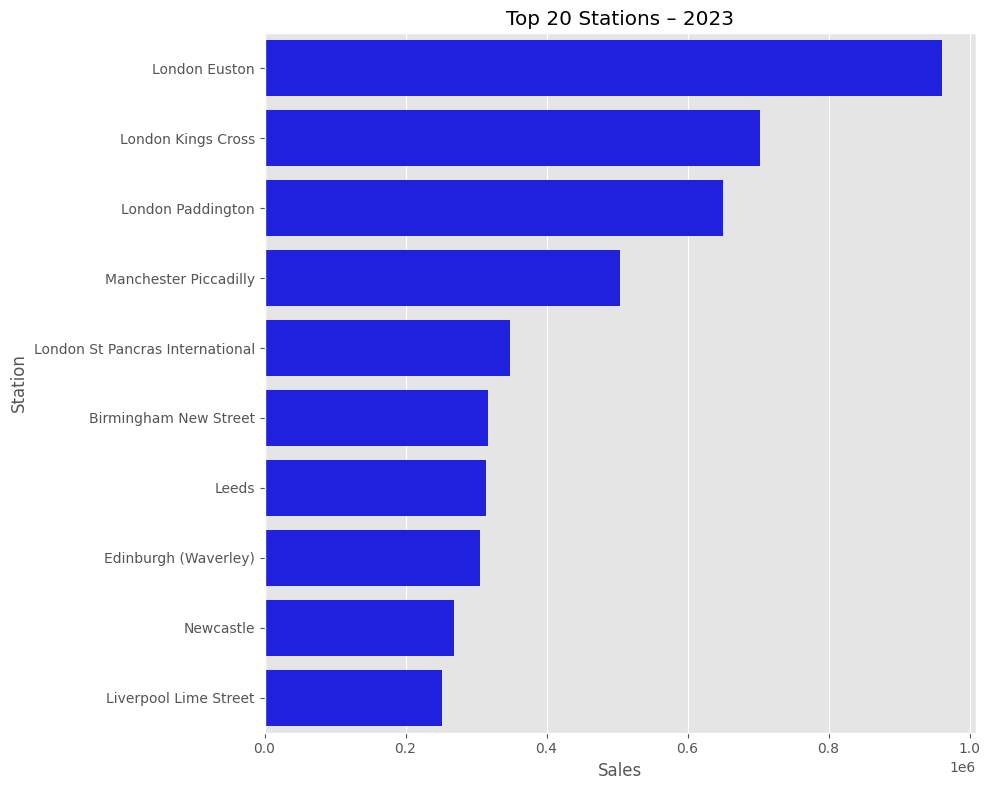

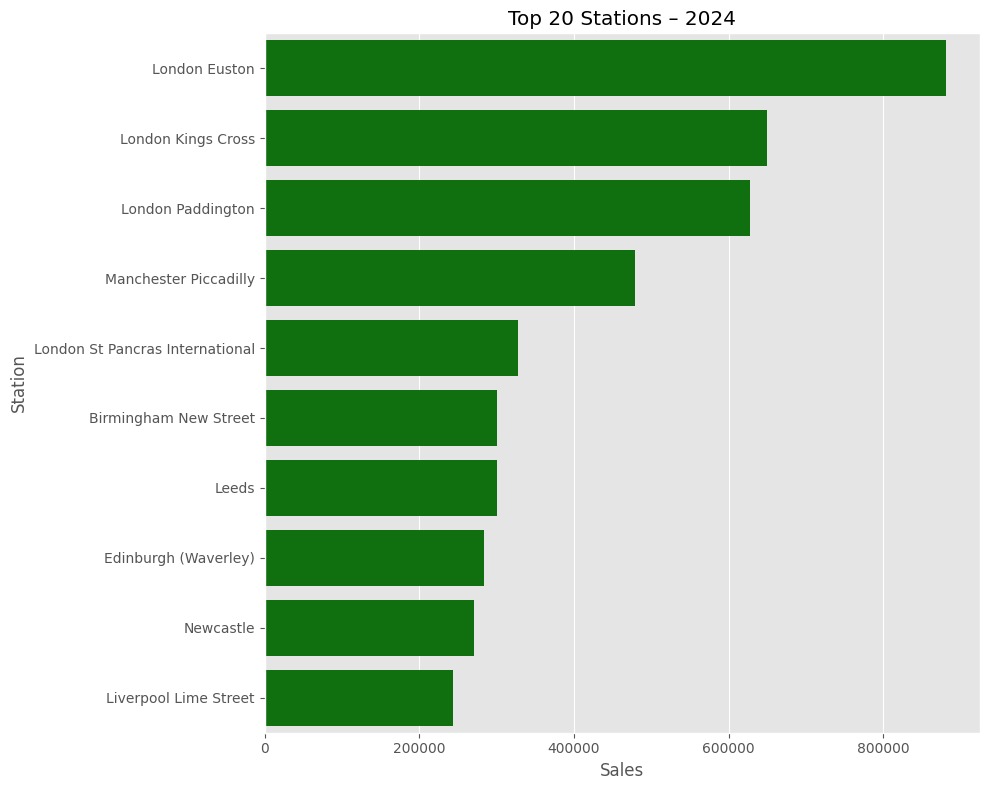

In [339]:
top_23 = (vis_df.query('year == 2023')
          .groupby('station', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

top_24 = (vis_df.query('year == 2024')
          .groupby('station', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=top_23, x='sales', y='station', color='blue')
plt.title('Top 20 Stations – 2023')
plt.xlabel('Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(data=top_24, x='sales', y='station', color='green')
plt.title('Top 20 Stations – 2024')
plt.xlabel('Sales')
plt.ylabel('Station')
plt.tight_layout()
plt.show()


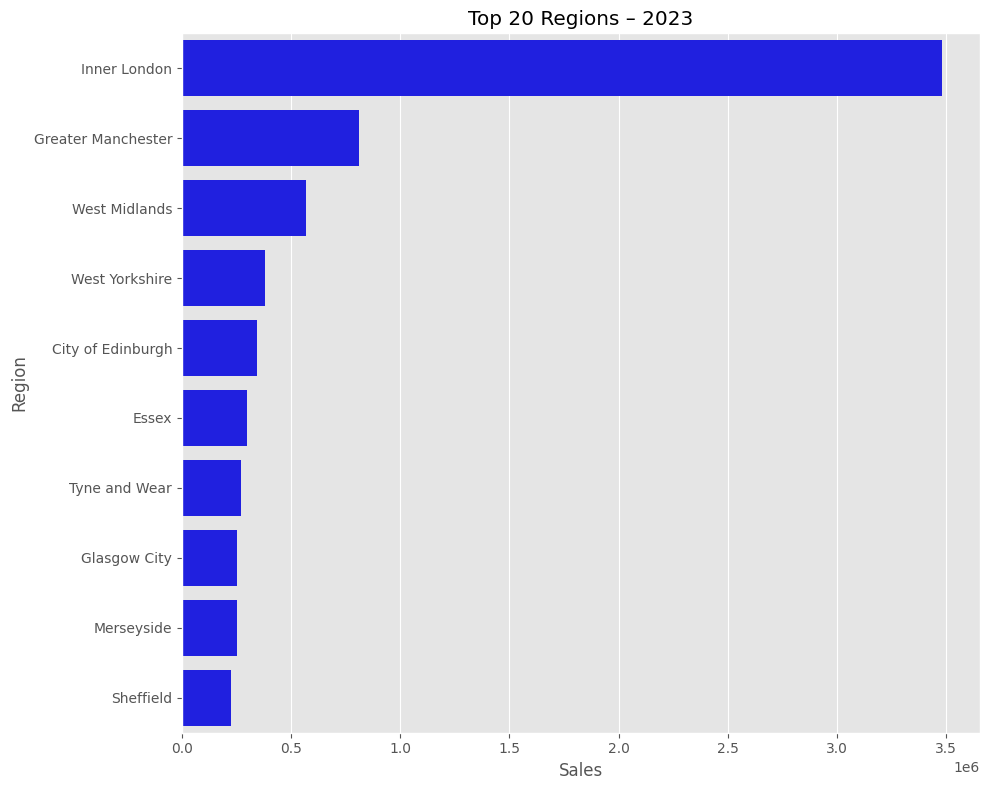

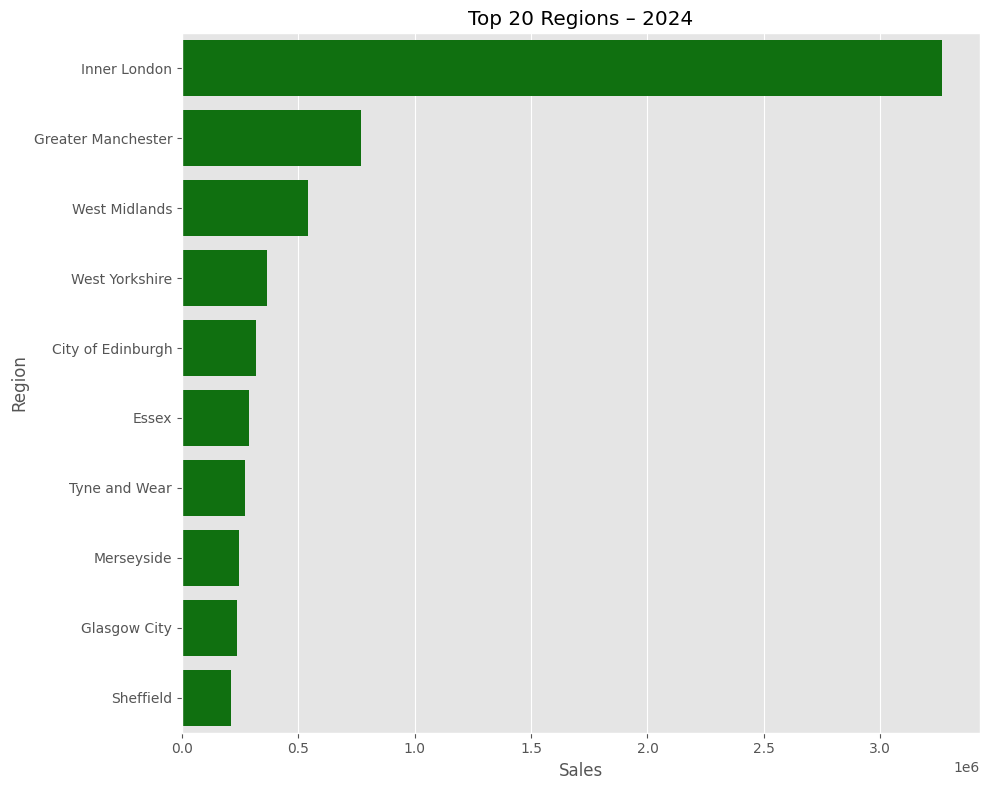

In [340]:
top_23 = (vis_df.query('year == 2023')
          .groupby('region', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

top_24 = (vis_df.query('year == 2024')
          .groupby('region', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=top_23, x='sales', y='region', color='blue')
plt.title('Top 20 Regions – 2023')
plt.xlabel('Sales')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(data=top_24, x='sales', y='region', color='green')
plt.title('Top 20 Regions – 2024')
plt.xlabel('Sales')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


In [341]:
top_23 = (vis_df.query('year == 2023')
          .groupby('nation', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

top_24 = (vis_df.query('year == 2024')
          .groupby('nation', as_index=False)['sales']
          .sum()
          .sort_values('sales', ascending=False)
          .head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=top_23, x='sales', y='nation', color='blue', hue='trainline_assisted_sales')
plt.title('Top 20 Nations – 2023')
plt.xlabel('Sales')
plt.ylabel('Nation')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(data=top_24, x='sales', y='nation', color='green', hue='trainline_assisted_sales')
plt.title('Top 20 Nations – 2024')
plt.xlabel('Sales')
plt.ylabel('Nation')
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `trainline_assisted_sales` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

## Modeling

***Modeling Ideas***

    - Predict highest networth / growth for a station in x months/years.
    - Short term - predict largest sales gain or total in x days.
    - Marketing campaigns to target workers? Travel between certain stations at a particular time will be workers, others tourists, others residents. A model cluster to categorise given a station/time of day/time of year a group to classify the majority as.